# EN 520.650 Project 2: CIFAR10 Classification & Attack & Defense

Author: Mo Zhou <mzhou32@jhu.edu>

Date: May 10. 2022

## Backbone Network

In this project, we train a standard ResNet-18 Model on the CIFAR-10 dataset
using the cross-entropy loss. SGD optimizer is used to update the model
parameters, with a learning rate 0.1 and momemtum 0.9. L-2 regularization
is also used with a weight 0.0002. The model is trained for 30 epoches
with a batch size 256. The learning rate is decayed by factor 0.1 at the
20th and the 25th epoch, respectively. The original ResNet paper trains
for 200 epochs. But I don't have so much spare GPU to do this right before
the NeurIPS dealine. So 30 epochs is enough for demonstration and 
proof of concept.

During adversarial training, we use the same settings for ResNet-18, but the
training samples are replaced with 6-step PGD adversarial examples on the fly.

Both the original model and the defensed model are evaluated using gaussian
noise, FGSM, PGD and CW attacks. Note, the question ask us to do adversarial
attack and defense on MNIST ... but I did these on CIFAR10. That's more useful
in the literature. A method worked very well does not necessarily generalize
on CIFAR10, let alone ImageNet.

The results and plots can be found in the last part.
The experiment is conducted on Google Colab platform.

## Code

The code is written on top of PyTorch and Pytorch-Lightning for convenience.

## 1. Preparation: download dataset and install required python packages

In [1]:
!nvidia-smi

Wed May 11 03:03:42 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!mkdir -p ~/.torch/
!wget -c https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
!tar xvf cifar-10-python.tar.gz -C ~/.torch

--2022-05-11 03:03:42--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  31.2MB/s    in 5.8s    

2022-05-11 03:03:50 (27.9 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [3]:
!pip3 install pytorch_lightning -q
!pip3 install torchattacks
!pip3 install rich

     |████████████████████████████████| 584 kB 14.0 MB/s 
     |████████████████████████████████| 596 kB 50.9 MB/s 
     |████████████████████████████████| 136 kB 74.0 MB/s 
     |████████████████████████████████| 409 kB 70.7 MB/s 
     |████████████████████████████████| 1.1 MB 54.8 MB/s 
     |████████████████████████████████| 144 kB 76.4 MB/s 
     |████████████████████████████████| 271 kB 75.0 MB/s 
     |████████████████████████████████| 94 kB 3.5 MB/s 
     |████████████████████████████████| 105 kB 14.4 MB/s 
     |████████████████████████████████| 231 kB 14.0 MB/s 
     |████████████████████████████████| 51 kB 8.9 MB/s 


## 2. Load necessary python packages

In [4]:
import os
import numpy as np
import torch as th
from torch.utils.data import Dataset
import torchvision as V
import pickle
from PIL import Image
import pytorch_lightning as thl
from torch.utils.data import DataLoader
import torchattacks as atk
import matplotlib.pyplot as plt
import rich
c = rich.get_console()

## 3. Set parameters, utility functions

In [5]:
# configurations
cifar10_path = os.path.expanduser('~/.torch/cifar-10-batches-py')
batch_size = 256
learning_rate = 1e-1
momentum = 9e-1
weight_decay = 2e-4
maxepoch = 30
Imean = th.tensor([0.485, 0.456, 0.406])
Istd = th.tensor([0.229, 0.224, 0.225])

def unpickle(file):
    with open(file, 'rb') as fo:
        dic = pickle.load(fo, encoding='latin1')
    return dic

def renorm(im):
    return im.sub(Imean[:, None, None].to(im.device)).div(
        Istd[:,None,None].to(im.device))

## 4. Create dataset class for CIFAR10

In [6]:
# create dataset class
class Cifar10Dataset(Dataset):
    '''
    CIFAR 10 Dataset Class
    '''
    def __init__(self, path, kind):
        # determine type {train, test}
        if kind == 'train':
            transform = V.transforms.Compose([
                V.transforms.RandomCrop(32, padding=4),
                V.transforms.RandomHorizontalFlip(),
                V.transforms.ToTensor(),
            ])
        elif kind == 'test':
            transform = V.transforms.Compose([
                V.transforms.ToTensor(),
            ])
        else:
            raise ValueError
        self.transform = transform
        # load dataset
        if kind == 'train':
            files = [f'data_batch_{x}' for x in range(1, 5+1)]
            files = [os.path.join(path, x) for x in files]
            images, labels = [], []
            for i in files:
                data = unpickle(i)
                images.append(data['data'])
                labels.extend(data['labels'])
            images = np.vstack(images).reshape(-1, 3, 32, 32)
            labels = np.array(labels)
        elif kind == 'test':
            file = os.path.join(path, 'test_batch')
            data = unpickle(file)
            images = np.array(data['data']).reshape(-1, 3, 32, 32)
            labels = np.array(data['labels'])
        else:
            raise ValueError
        self.images = images
        self.labels = labels
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        image = Image.fromarray(self.images[idx].transpose((1,2,0)))
        label = self.labels[idx]
        if self.transform is not None:
            image = self.transform(image)
        return image, label

## 5. Create resnet18 model in pytorch-lightning API

In [7]:
# create resnet 18 model
class ResNet18(thl.LightningModule):
    
    def __init__(self, defensive=False):
        super().__init__()
        # create resnet18 backbone
        self.backbone = V.models.resnet18(False)
        # perform surgery
        self.backbone.fc = th.nn.Linear(512, 10)
        # save settings: do we adversarially train?
        if defensive:
            self.defensive = atk.PGD(self.backbone, eps=8/255, alpha=2/255,
                                     steps=7, random_start=True)
        else:
            self.defensive = None
        
    def setup(self, stage=None):
        # instantiate dataset objects
        TrainDataset = Cifar10Dataset(cifar10_path, 'train')
        TestDataset = Cifar10Dataset(cifar10_path, 'test')
        print('* training set size', len(TrainDataset))
        print('* test set size', len(TestDataset))
        self.data_train = TrainDataset
        self.data_val = TestDataset
        self.data_test = None
        
    def train_dataloader(self):
        train_loader = DataLoader(self.data_train,
                                  batch_size=batch_size,
                                  shuffle=True,
                                  pin_memory=True,
                                  num_workers=2)
        return train_loader
    
    def val_dataloader(self):
        val_loader = DataLoader(self.data_val,
                               batch_size=batch_size,
                               pin_memory=True,
                               num_workers=2)
        return val_loader
    
    def configure_optimizers(self):
        optim = th.optim.SGD(self.parameters(),
                    lr=learning_rate, momentum=momentum,
                    weight_decay=weight_decay)
        scheduler = th.optim.lr_scheduler.MultiStepLR(
            optim, milestones=[20, 25], gamma=0.1)
        return [optim], [scheduler]
    
    def forward(self, x):
        with th.no_grad():
            x = renorm(x)
        x = self.backbone(x)
        return x
    
    def training_step(self, batch, batch_idx):
        # This is a simple dispatcher. If defensive, we switch to
        # adversarial training instead.
        if self.defensive is not None:
            return self.adversarial_training_step(batch, batch_idx)
        images, labels = (batch[0].to(self.device), batch[1].to(self.device))
        output = self.forward(images)
        loss = th.nn.functional.cross_entropy(output, labels)
        self.log('Train/loss', loss.item())
        accuracy = output.max(1)[1].eq(
            labels.view(-1)).sum().item() / labels.nelement()
        self.log('Train/accuracy', accuracy)
        return loss

    def adversarial_training_step(self, batch, batch_idx):
        # create adversarial examples
        self.eval()
        images, labels = (batch[0].to(self.device), batch[1].to(self.device))
        self.defensive.device = 'cuda'
        adv_images = self.defensive(images, labels)
        adv_images = adv_images.to(self.device)
        self.train()
        output = self.forward(adv_images)
        loss = th.nn.functional.cross_entropy(output, labels)
        self.log('Train/loss', loss.item())
        accuracy = output.max(1)[1].eq(
            labels.view(-1)).sum().item() / labels.nelement()
        self.log('Train/accuracy', accuracy)
        return loss
    
    def validation_step(self, batch, batch_idx):
        images, labels = (batch[0].to(self.device), batch[1].to(self.device))
        output = self.forward(images)
        loss = th.nn.functional.cross_entropy(output, labels)
        self.log('Validate/loss', loss.item())
        accuracy = output.max(1)[1].eq(
            labels.view(-1)).sum().item() / labels.nelement()
        self.log('Validate/accuracy', accuracy)
        return {'loss': loss.item(), 'accuracy': accuracy}
    
    def validation_epoch_end(self, outputs):
        summary = {key: np.mean(tuple(x[key] for x in outputs))
                   for key in outputs[0].keys()}
        print('Validate: loss=', summary['loss'],
              'accuracy=', summary['accuracy'], end='')

## 6. Define trainer and metric tracker

In [8]:
# define data collector
class MetricTracker(thl.callbacks.Callback):
  def __init__(self):
    self.tloss = []
    self.tacc = []
    self.vloss = []
    self.vacc = []

  def on_train_batch_end(self, trainer, module, *argv):
    outputs = trainer.logged_metrics
    self.tloss.append(outputs['Train/loss'])
    self.tacc.append(outputs['Train/accuracy'])

  def on_validation_epoch_end(self, trainer, module):
    outputs = trainer.logged_metrics
    self.vloss.append(outputs['Validate/loss'])
    self.vacc.append(outputs['Validate/accuracy'])


# define training loop
class Train(object):
    def __init__(self, defensive=False):
        print('* Initializing model ...')
        model = ResNet18(defensive=defensive)
        self.cb = MetricTracker()
        
        print('* Start training loop ...')
        trainer = thl.Trainer(max_epochs=maxepoch,
                              log_every_n_steps=1,
                              check_val_every_n_epoch=1,
                              gpus=th.cuda.device_count(),
                              accelerator='none',
                              callbacks=[self.cb],
                              )
        trainer.fit(model)
        print('* finished training ...')
        self.model = model

## 7. Standard Training process and metric curves

In [9]:
standard_train = Train()

* Initializing model ...


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /content/lightning_logs


* Start training loop ...
* training set size 50000
* test set size 10000


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type   | Params
------------------------------------
0 | backbone | ResNet | 11.2 M
------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Validate: loss= 2.355788826942444 accuracy= 0.0859375

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validate: loss= 1.9889973729848862 accuracy= 0.3525390625

Validation: 0it [00:00, ?it/s]

Validate: loss= 1.4163841515779496 accuracy= 0.48759765625

Validation: 0it [00:00, ?it/s]

Validate: loss= 1.3094121307134627 accuracy= 0.53388671875

Validation: 0it [00:00, ?it/s]

Validate: loss= 1.1570362895727158 accuracy= 0.584375

Validation: 0it [00:00, ?it/s]

Validate: loss= 0.9993576288223267 accuracy= 0.64267578125

Validation: 0it [00:00, ?it/s]

Validate: loss= 0.9809375211596489 accuracy= 0.66083984375

Validation: 0it [00:00, ?it/s]

Validate: loss= 0.9380733922123909 accuracy= 0.669140625

Validation: 0it [00:00, ?it/s]

Validate: loss= 0.8905474275350571 accuracy= 0.6943359375

Validation: 0it [00:00, ?it/s]

Validate: loss= 0.8449772492051124 accuracy= 0.6978515625

Validation: 0it [00:00, ?it/s]

Validate: loss= 0.8525842934846878 accuracy= 0.705859375

Validation: 0it [00:00, ?it/s]

Validate: loss= 0.8101161703467369 accuracy= 0.72099609375

Validation: 0it [00:00, ?it/s]

Validate: loss= 0.7245676189661026 accuracy= 0.74912109375

Validation: 0it [00:00, ?it/s]

Validate: loss= 0.7091854572296142 accuracy= 0.75869140625

Validation: 0it [00:00, ?it/s]

Validate: loss= 0.7444381564855576 accuracy= 0.73642578125

Validation: 0it [00:00, ?it/s]

Validate: loss= 0.7037450492382049 accuracy= 0.75576171875

Validation: 0it [00:00, ?it/s]

Validate: loss= 0.7043260663747788 accuracy= 0.75908203125

Validation: 0it [00:00, ?it/s]

Validate: loss= 0.6880998194217682 accuracy= 0.76435546875

Validation: 0it [00:00, ?it/s]

Validate: loss= 0.6678396470844745 accuracy= 0.7669921875

Validation: 0it [00:00, ?it/s]

Validate: loss= 0.6884112194180488 accuracy= 0.76943359375

Validation: 0it [00:00, ?it/s]

Validate: loss= 0.6455107949674129 accuracy= 0.78388671875

Validation: 0it [00:00, ?it/s]

Validate: loss= 0.5271872144192458 accuracy= 0.820703125

Validation: 0it [00:00, ?it/s]

Validate: loss= 0.5204365637153388 accuracy= 0.823828125

Validation: 0it [00:00, ?it/s]

Validate: loss= 0.5179242104291916 accuracy= 0.82578125

Validation: 0it [00:00, ?it/s]

Validate: loss= 0.5176286973059178 accuracy= 0.82578125

Validation: 0it [00:00, ?it/s]

Validate: loss= 0.5174185141921044 accuracy= 0.827734375

Validation: 0it [00:00, ?it/s]

Validate: loss= 0.5127267278730869 accuracy= 0.8275390625

Validation: 0it [00:00, ?it/s]

Validate: loss= 0.5093417923897505 accuracy= 0.82890625

Validation: 0it [00:00, ?it/s]

Validate: loss= 0.510973670706153 accuracy= 0.82880859375

Validation: 0it [00:00, ?it/s]

Validate: loss= 0.5111811898648739 accuracy= 0.82958984375

Validation: 0it [00:00, ?it/s]

Validate: loss= 0.510463486239314 accuracy= 0.830078125* finished training ...


Text(0.5, 1.0, 'validation accuracy')

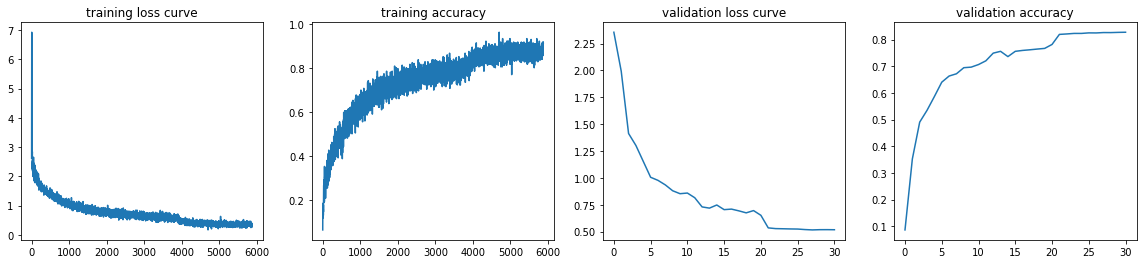

In [10]:
plt.figure(figsize=(20,4))
plt.subplot(1,4,1)
plt.plot([x.item() for x in standard_train.cb.tloss])
plt.title('training loss curve')
plt.subplot(1,4,2)
plt.plot([x.item() for x in standard_train.cb.tacc])
plt.title('training accuracy')
plt.subplot(1,4,3)
plt.plot([x.item() for x in standard_train.cb.vloss])
plt.title('validation loss curve')
plt.subplot(1,4,4)
plt.plot([x.item() for x in standard_train.cb.vacc])
plt.title('validation accuracy')

## 8. Robustness Evaluation for standard model (no defense)

In [11]:
class RobustEval(object):
    def __init__(self, model):
        self.model = model

    def eval(self, attack, epsilon:float) -> float:
        from rich.progress import track
        self.model.eval()
        val_loader = self.model.val_dataloader()
        numbers = []
        for (images, labels) in track(val_loader,
                      description=f'Attack w/ eps={epsilon}'):
            adv_images = attack(images, labels)
            output = self.model.forward(adv_images)
            accuracy = output.max(1)[1].eq(
               labels.view(-1)).sum().item() / labels.nelement()
            numbers.append(accuracy)
            if len(numbers) >= 10:
                break
        return th.tensor(numbers).mean().item()

    def eval_gaussian_auto(self):
        from rich.table import Table
        table = Table(title="Gaussian Attack")
        table.add_column('Epsilon')
        table.add_column('Accuracy')
        for (epsf, epss) in zip([2/255, 4/255, 8/255],
                                ['2/255', '4/255', '8/255']):
            attack = atk.GN(self.model.backbone, std=epsf)
            acc = self.eval(attack, epsf)
            table.add_row(epss, str(acc))
        c.print(table)

    def eval_fgsm_auto(self):
        from rich.table import Table
        table = Table(title="FGSM Attack")
        table.add_column('Epsilon')
        table.add_column('Accuracy')
        for (epsf, epss) in zip([2/255, 4/255, 8/255],
                                ['2/255', '4/255', '8/255']):
            attack = atk.FGSM(self.model.backbone, eps=epsf)
            acc = self.eval(attack, epsf)
            table.add_row(epss, str(acc))
        c.print(table)

    def eval_pgd_auto(self):
        from rich.table import Table
        table = Table(title="PGD Attack")
        table.add_column('Epsilon')
        table.add_column('Accuracy')
        for (epsf, epss) in zip([2/255, 4/255, 8/255],
                                ['2/255', '4/255', '8/255']):
            attack = atk.PGD(self.model.backbone, eps=epsf, steps=6)
            acc = self.eval(attack, epsf)
            table.add_row(epss, str(acc))
        c.print(table)

    def eval_cw_auto(self):
        from rich.table import Table
        table = Table(title="CW Attack")
        table.add_column('Parameter c')
        table.add_column('Accuracy')
        for (epsf, epss) in zip([1e1, 1e2, 1e4],
                                ['1.0', '10.0', '10000.0']):
            attack = atk.CW(self.model.backbone, c=epsf, steps=100, lr=0.1)
            acc = self.eval(attack, epsf)
            table.add_row(epss, str(acc))
        c.print(table)

    def eval_all(self):
        self.eval_gaussian_auto()
        self.eval_fgsm_auto()
        self.eval_pgd_auto()
        # CW is super slow ... 
        self.eval_cw_auto()

In [12]:
std_eval = RobustEval(standard_train.model)
std_eval.eval_all()

Output()

Output()

Output()

        Gaussian Attack        
┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Epsilon ┃ Accuracy          ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ 2/255   │ 0.826953113079071 │
│ 4/255   │ 0.826171875       │
│ 8/255   │ 0.823437511920929 │
└─────────┴───────────────────┘

Output()

Output()

Output()

          FGSM Attack          
┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Epsilon ┃ Accuracy          ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ 2/255   │ 0.72265625        │
│ 4/255   │ 0.585156261920929 │
│ 8/255   │ 0.3671875         │
└─────────┴───────────────────┘

Output()

Output()

Output()

           PGD Attack           
┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ Epsilon ┃ Accuracy           ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ 2/255   │ 0.721484363079071  │
│ 4/255   │ 0.5757812261581421 │
│ 8/255   │ 0.3046875          │
└─────────┴────────────────────┘

Output()

Output()

Output()

             CW Attack              
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ Parameter c ┃ Accuracy           ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ 1.0         │ 0.7347656488418579 │
│ 10.0        │ 0.707812488079071  │
│ 10000.0     │ 0.66015625         │
└─────────────┴────────────────────┘

## 9. Adversarial training and performance curves

In [13]:
adversarial_train = Train(defensive=True)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


* Initializing model ...
* Start training loop ...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type   | Params
------------------------------------
0 | backbone | ResNet | 11.2 M
------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)


* training set size 50000
* test set size 10000


Sanity Checking: 0it [00:00, ?it/s]

Validate: loss= 2.3434373140335083 accuracy= 0.099609375

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validate: loss= 1.7702793151140213 accuracy= 0.34912109375

Validation: 0it [00:00, ?it/s]

Validate: loss= 1.7645467281341554 accuracy= 0.3994140625

Validation: 0it [00:00, ?it/s]

Validate: loss= 1.5678640007972717 accuracy= 0.43515625

Validation: 0it [00:00, ?it/s]

Validate: loss= 1.6631443679332734 accuracy= 0.45068359375

Validation: 0it [00:00, ?it/s]

Validate: loss= 1.432450035214424 accuracy= 0.477734375

Validation: 0it [00:00, ?it/s]

Validate: loss= 1.3877696812152862 accuracy= 0.50009765625

Validation: 0it [00:00, ?it/s]

Validate: loss= 1.4211691439151763 accuracy= 0.49521484375

Validation: 0it [00:00, ?it/s]

Validate: loss= 1.3118683516979217 accuracy= 0.5337890625

Validation: 0it [00:00, ?it/s]

Validate: loss= 1.275204238295555 accuracy= 0.5515625

Validation: 0it [00:00, ?it/s]

Validate: loss= 1.2997358009219169 accuracy= 0.53984375

Validation: 0it [00:00, ?it/s]

Validate: loss= 1.2955846667289734 accuracy= 0.53779296875

Validation: 0it [00:00, ?it/s]

Validate: loss= 1.1920660451054572 accuracy= 0.59189453125

Validation: 0it [00:00, ?it/s]

Validate: loss= 1.1699092015624046 accuracy= 0.5912109375

Validation: 0it [00:00, ?it/s]

Validate: loss= 1.153179931640625 accuracy= 0.58603515625

Validation: 0it [00:00, ?it/s]

Validate: loss= 1.0765358090400696 accuracy= 0.62763671875

Validation: 0it [00:00, ?it/s]

Validate: loss= 1.1391814291477202 accuracy= 0.60166015625

Validation: 0it [00:00, ?it/s]

Validate: loss= 1.1957459971308708 accuracy= 0.585546875

Validation: 0it [00:00, ?it/s]

Validate: loss= 1.0982186943292618 accuracy= 0.61708984375

Validation: 0it [00:00, ?it/s]

Validate: loss= 1.0976988524198532 accuracy= 0.62802734375

Validation: 0it [00:00, ?it/s]

Validate: loss= 1.1134317427873612 accuracy= 0.6306640625

Validation: 0it [00:00, ?it/s]

Validate: loss= 0.9217815726995469 accuracy= 0.67841796875

Validation: 0it [00:00, ?it/s]

Validate: loss= 0.9119673199951649 accuracy= 0.68837890625

Validation: 0it [00:00, ?it/s]

Validate: loss= 0.9123720526695251 accuracy= 0.6822265625

Validation: 0it [00:00, ?it/s]

Validate: loss= 0.9003920458257199 accuracy= 0.6845703125

Validation: 0it [00:00, ?it/s]

Validate: loss= 0.9225208014249802 accuracy= 0.6822265625

Validation: 0it [00:00, ?it/s]

Validate: loss= 0.9003451965749264 accuracy= 0.683984375

Validation: 0it [00:00, ?it/s]

Validate: loss= 0.9054338708519936 accuracy= 0.68291015625

Validation: 0it [00:00, ?it/s]

Validate: loss= 0.9055464275181293 accuracy= 0.68125

Validation: 0it [00:00, ?it/s]

Validate: loss= 0.9059427723288536 accuracy= 0.68310546875

Validation: 0it [00:00, ?it/s]

Validate: loss= 0.9104090794920922 accuracy= 0.68251953125* finished training ...


Text(0.5, 1.0, 'validation accuracy')

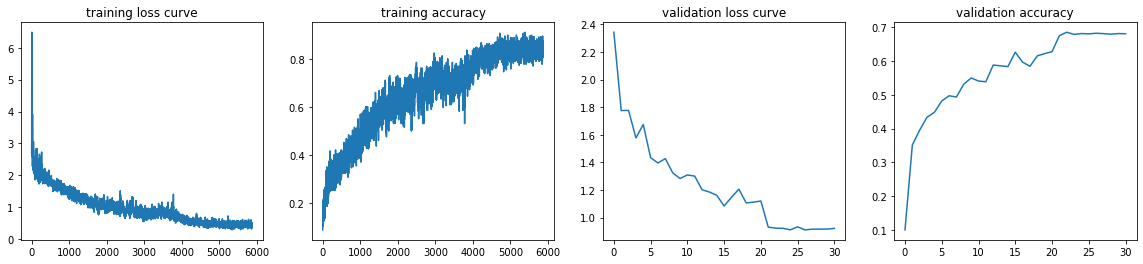

In [14]:
plt.figure(figsize=(20,4))
plt.subplot(1,4,1)
plt.plot([x.item() for x in adversarial_train.cb.tloss])
plt.title('training loss curve')
plt.subplot(1,4,2)
plt.plot([x.item() for x in adversarial_train.cb.tacc])
plt.title('training accuracy')
plt.subplot(1,4,3)
plt.plot([x.item() for x in adversarial_train.cb.vloss])
plt.title('validation loss curve')
plt.subplot(1,4,4)
plt.plot([x.item() for x in adversarial_train.cb.vacc])
plt.title('validation accuracy')

## 10. Robustness evaluation for adversarially trained model

In [15]:
adv_eval = RobustEval(adversarial_train.model)
adv_eval.eval_all()

Output()

Output()

Output()

        Gaussian Attack        
┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Epsilon ┃ Accuracy          ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ 2/255   │ 0.693359375       │
│ 4/255   │ 0.690234363079071 │
│ 8/255   │ 0.685546875       │
└─────────┴───────────────────┘

Output()

Output()

Output()

          FGSM Attack          
┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Epsilon ┃ Accuracy          ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ 2/255   │ 0.689453125       │
│ 4/255   │ 0.685546875       │
│ 8/255   │ 0.663281261920929 │
└─────────┴───────────────────┘

Output()

Output()

Output()

           PGD Attack           
┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ Epsilon ┃ Accuracy           ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ 2/255   │ 0.6910156011581421 │
│ 4/255   │ 0.6878906488418579 │
│ 8/255   │ 0.671875           │
└─────────┴────────────────────┘

Output()

Output()

Output()

             CW Attack              
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ Parameter c ┃ Accuracy           ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ 1.0         │ 0.6761718988418579 │
│ 10.0        │ 0.665234386920929  │
│ 10000.0     │ 0.655078113079071  │
└─────────────┴────────────────────┘

## 11. Conclusions

For standard training, the max epoch has been reduced to 30, but the accuracy is still able to reach 82.6% on the test set. In section 8, we test its adversarial robustness. It can be seen that Gaussian noise not quite adversarial, and does not clearly change the classification success rate.
FGSM is a single step attack, and we can see decreasing robust accuracy
as epsilon increasing for the attack. The stronger version of FGSM, namely PGD, is clearly more effective on compromising the neural network performance. For example, the PGD attack with the largest perturbation we used reduced the robust
accuracy to 30.4%. Note, CW attack could have been stronger, but since the attack runs super slow even on Colab's Nvidia P100 GPU, so I changed the attack parameters in order to make it run faster. As a result, this leads to weaker
attack effect. The PGD attack could be stronger with larger epsilon or larger
step number, but the current results are already enough for demonstrating effectiveness.

For adversarial training, it is very clearly seen that the standard adversarial training suffers from more generliazation gap issue, as the performance on beign examples is only 68%. This is commonly seen in the literature. However, the network robustness has been significantly improvemed in return. For example, the strongest PGD attack in our settings can only reduce its performance to 67.2%. A clear robustness improvement is seen.